## Libraries

In [1]:
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot
import itertools
import pickle

## Data

In [2]:
df_raw = pd.read_pickle('data/cleaned_df.pkl')
df_raw.head()

,date,UnitedStates,NewYorkNY,LosAngelesCA,ChicagoIL,DallasTX,HoustonTX,WashingtonDC,MiamiFL,PhiladelphiaPA,...,PecosTX,AtchisonKS,SpencerIA,SweetwaterTX,VermillionSD,ZapataTX,KetchikanAK,CraigCO,LamesaTX,VernonTX
0,2000-01-31,128276.0,226266.0,240598.0,170254.0,129923.0,127011.0,200209.0,140286.0,131271.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102246.0,NaN,NaN
1,2000-02-29,128617.0,227618.0,241457.0,170658.0,130024.0,127075.0,200484.0,140825.0,131708.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102636.0,NaN,NaN
2,2000-03-31,128973.0,228829.0,242727.0,171176.0,130113.0,126950.0,200883.0,141306.0,131976.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103269.0,NaN,NaN
3,2000-04-30,129698.0,231213.0,245142.0,172211.0,130326.0,127064.0,201744.0,142247.0,132634.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104029.0,NaN,NaN
4,2000-05-31,130427.0,233418.0,247707.0,173301.0,130543.0,127071.0,202922.0,143018.0,133157.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104795.0,NaN,NaN


## Forecast 5 Test Regions
"NewYorkNY", "LosAngelesCA", "RaleighNC", "SaltLakeCityUT", "OklahomaCityOK"

#### Create df for each region

In [3]:
dfNY = df_raw[["date", "NewYorkNY"]] # subset
dfNY.columns = ["ds", "y"] # rename columns to work with prophet

dfCA = df_raw[["date", "LosAngelesCA"]]
dfCA.columns = ["ds", "y"]

dfNC = df_raw[["date", "RaleighNC"]]
dfNC.columns = ["ds", "y"]

dfUT = df_raw[["date", "SaltLakeCityUT"]]
dfUT.columns = ["ds", "y"]

dfOK = df_raw[["date", "OklahomaCityOK"]]
dfOK.columns = ["ds", "y"]

locs = ["dfNY", "dfCA", "dfNC", "dfUT", "dfOK"]

### Base Model

In [4]:
# create model object for each location
mNY = Prophet()
mCA = Prophet()
mNC = Prophet()
mUT = Prophet()
mOK = Prophet()

# organize models and dfs into lists for future use
models = [mNY, mCA, mNC, mUT, mOK]
dfs = [dfNY, dfCA, dfNC, dfUT, dfOK]

In [5]:
# fit each model on it's df. Fitted models are still in list called models
for i in range(len(models)):
    models[i].fit(dfs[i])

15:33:19 - cmdstanpy - INFO - Chain [1] start processing
15:33:19 - cmdstanpy - INFO - Chain [1] done processing
15:33:19 - cmdstanpy - INFO - Chain [1] start processing
15:33:19 - cmdstanpy - INFO - Chain [1] done processing
15:33:19 - cmdstanpy - INFO - Chain [1] start processing
15:33:19 - cmdstanpy - INFO - Chain [1] done processing
15:33:19 - cmdstanpy - INFO - Chain [1] start processing
15:33:19 - cmdstanpy - INFO - Chain [1] done processing
15:33:19 - cmdstanpy - INFO - Chain [1] start processing
15:33:19 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# create list called future containing df with future dates for each model
future =[]
for i in range(len(models)):
    future.append(models[i].make_future_dataframe(periods=36, freq='MS'))

In [7]:
future[0]

,ds
0,2000-01-31
1,2000-02-29
2,2000-03-31
3,2000-04-30
4,2000-05-31
...,...
307,2025-08-01
308,2025-09-01
309,2025-10-01
310,2025-11-01


In [8]:
# create list called forecast containing df with forecasts for each model
forecast =[]
for i in range(len(models)):
    forecast.append(models[i].predict(future[i]))

### Plot

NewYorkNY

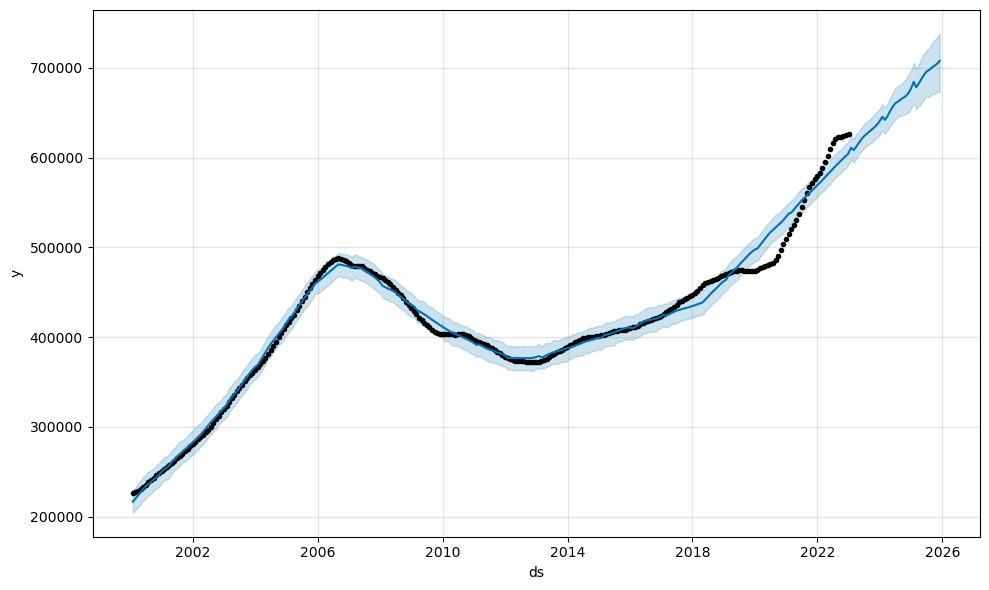

In [9]:
figNY = models[0].plot(forecast[0])

LosAngelesCA

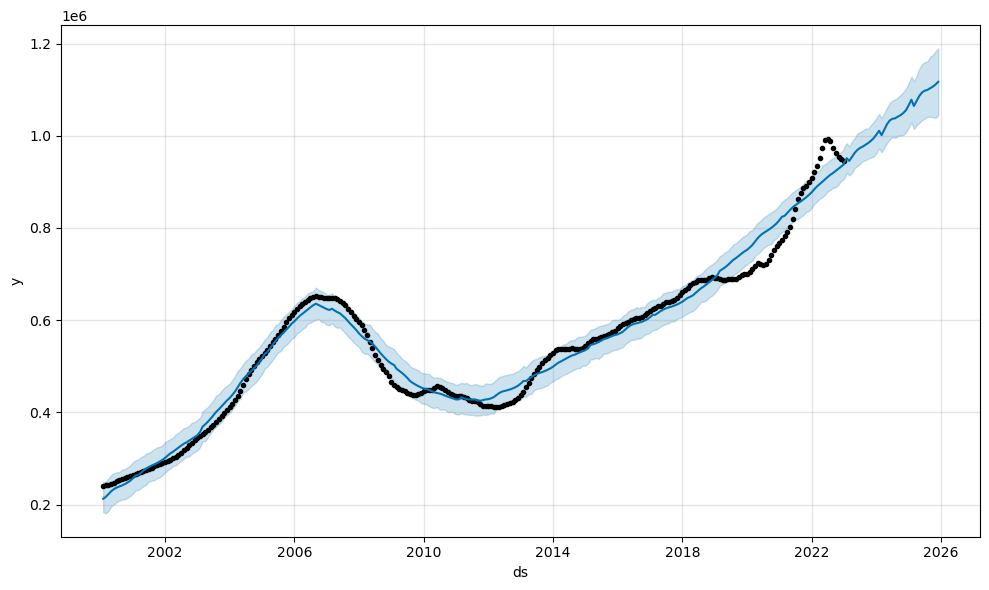

In [10]:
figCA = models[1].plot(forecast[1])

RaleighNC

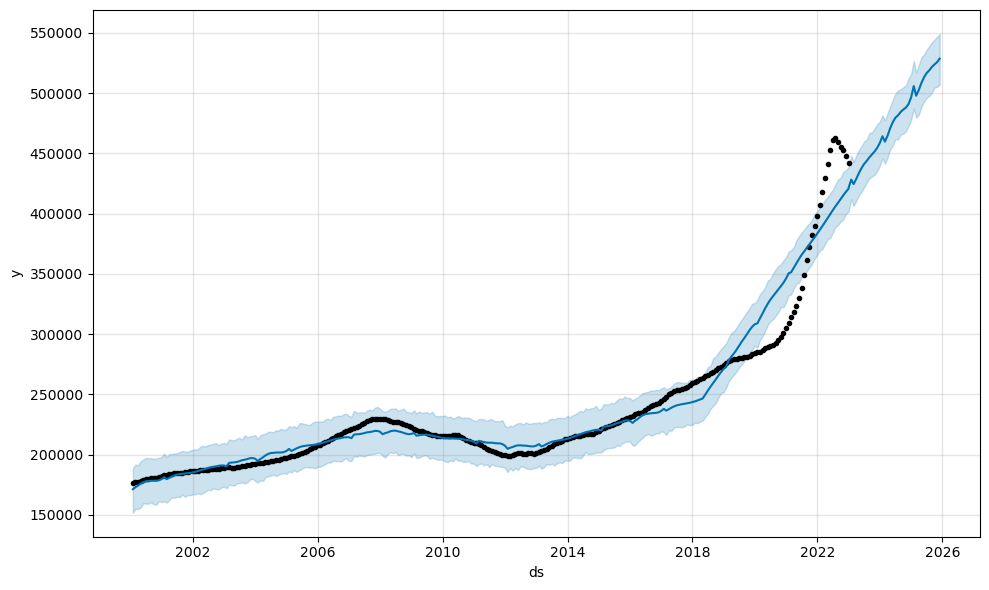

In [11]:
figNC = models[2].plot(forecast[2])

SaltLakeCityUT

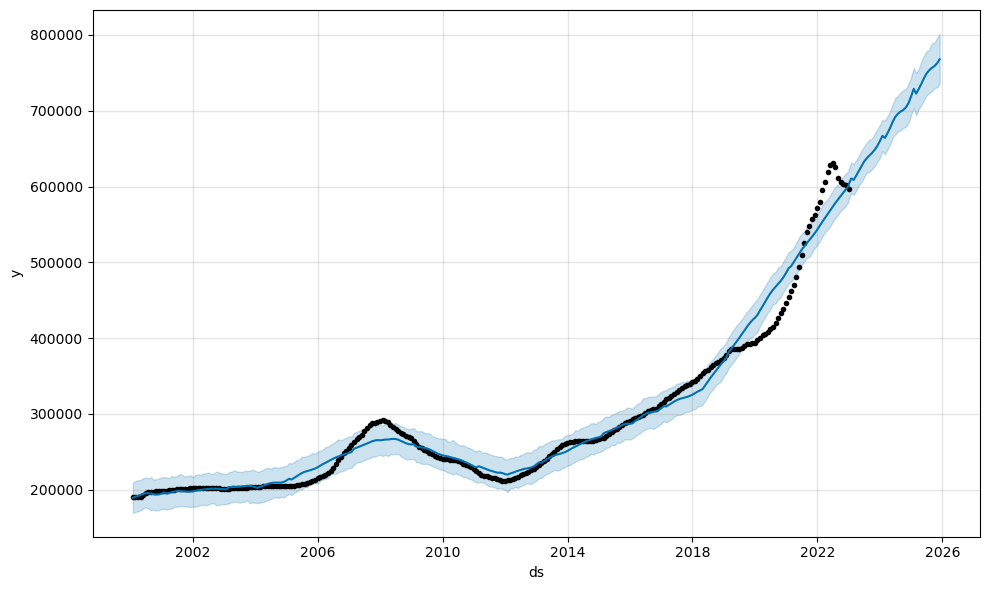

In [12]:
figUT = models[3].plot(forecast[3])

OklahomaCityOK

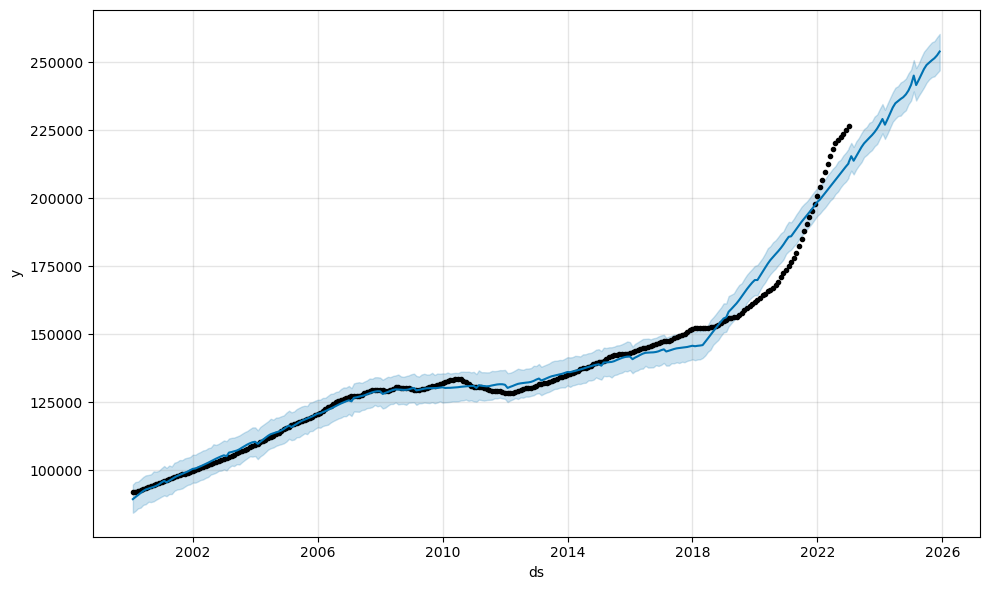

In [13]:
figOK = models[4].plot(forecast[4])

## COVID 19
Treat as a one-off holiday

In [14]:
# ended up not using

# from date of first lockdown to end of last

covid = pd.DataFrame([
    {'holiday': 'covid', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2021-06-10'}
])
for t_col in ['ds', 'ds_upper']:
    covid[t_col] = pd.to_datetime(covid[t_col]) # make datetime
covid['upper_window'] = (covid['ds_upper'] - covid['ds']).dt.days

covid
# Prophet assumes these are not recurring holidays
# Include holidays=covid in model parameters

,holiday,ds,lower_window,ds_upper,upper_window
0,covid,2020-03-21,0,2021-06-10,446


## Hyperparameter tuning

Define cutoffs and parameter grid

In [15]:
# create cutoffs to match: initial=10 years, period=6 months
cutoffs = pd.to_datetime(['2010-01-31', '2010-07-31', '2011-01-31', '2011-07-31', 
                         '2012-01-31', '2012-07-31', '2013-01-31', '2013-07-31', 
                         '2014-01-31', '2014-07-31', '2015-01-31', '2015-07-31', 
                         '2016-01-31', '2016-07-31', '2017-01-31', '2017-07-31', 
                         '2018-01-31', '2018-07-31', '2019-01-31', '2019-07-31', 
                         '2020-01-31', '2020-07-31', '2021-01-31', '2021-07-31'])

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

Find best parameters

In [16]:
# create dict for rmse to go 
rmses = [[],[],[],[],[]]

In [17]:
# Use cross validation to evaluate all parameters
for params in all_params:
    for i in range(len(models)):
        m = Prophet(**params, changepoint_range=0.9) # include covid and changepoint
        m.fit(dfs[i])  # Fit model with given params to correct df
        df_cv = cross_validation(m, cutoffs=cutoffs, horizon="365 days", parallel="processes")
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses[i].append(df_p['rmse'].values[0])

15:33:20 - cmdstanpy - INFO - Chain [1] start processing
15:33:20 - cmdstanpy - INFO - Chain [1] done processing
15:33:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:33:20 - cmdstanpy - INFO - Chain [1] start processing
15:33:22 - cmdstanpy - INFO - Chain [1] done processing
15:33:26 - cmdstanpy - INFO - Chain [1] start processing
15:33:26 - cmdstanpy - INFO - Chain [1] start processing
15:33:26 - cmdstanpy - INFO - Chain [1] done processing
15:33:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:33:26 - cmdstanpy - INFO - Chain [1] start processing
15:33:26 - cmdstanpy - INFO - Chain [1] done processing
15:33:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:33:26 - cmdstanpy - INFO -

15:33:31 - cmdstanpy - INFO - Chain [1] start processing
15:33:31 - cmdstanpy - INFO - Chain [1] start processing
15:33:31 - cmdstanpy - INFO - Chain [1] start processing
15:33:31 - cmdstanpy - INFO - Chain [1] done processing
15:33:31 - cmdstanpy - INFO - Chain [1] start processing
15:33:31 - cmdstanpy - INFO - Chain [1] done processing
15:33:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:33:32 - cmdstanpy - INFO - Chain [1] start processing
15:33:32 - cmdstanpy - INFO - Chain [1] done processing
15:33:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:33:32 - cmdstanpy - INFO - Chain [1] start processing
15:33:32 - cmdstanpy - INFO - Chain [1] start processing
15:33:32 - cmdstanpy - INFO - Chain [1] done processing
15:33:32 - cmdstanpy - ERROR - Chain [1] error: error during processi

15:33:38 - cmdstanpy - INFO - Chain [1] start processing
15:33:38 - cmdstanpy - INFO - Chain [1] done processing
15:33:38 - cmdstanpy - INFO - Chain [1] done processing
15:33:38 - cmdstanpy - INFO - Chain [1] done processing
15:33:38 - cmdstanpy - INFO - Chain [1] done processing
15:33:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:33:38 - cmdstanpy - INFO - Chain [1] done processing
15:33:38 - cmdstanpy - INFO - Chain [1] start processing
15:33:38 - cmdstanpy - INFO - Chain [1] start processing
15:33:38 - cmdstanpy - INFO - Chain [1] start processing
15:33:38 - cmdstanpy - INFO - Chain [1] start processing
15:33:38 - cmdstanpy - INFO - Chain [1] done processing
15:33:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:33:38 - cmdstanpy - INFO - Chain [1] start processing
15:33:38 - cmd

15:33:45 - cmdstanpy - INFO - Chain [1] start processing
15:33:45 - cmdstanpy - INFO - Chain [1] done processing
15:33:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:33:45 - cmdstanpy - INFO - Chain [1] start processing
15:33:45 - cmdstanpy - INFO - Chain [1] done processing
15:33:45 - cmdstanpy - INFO - Chain [1] start processing
15:33:45 - cmdstanpy - INFO - Chain [1] done processing
15:33:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:33:45 - cmdstanpy - INFO - Chain [1] start processing
15:33:45 - cmdstanpy - INFO - Chain [1] done processing
15:33:45 - cmdstanpy - INFO - Chain [1] start processing
15:33:45 - cmdstanpy - INFO - Chain [1] done processing
15:33:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormall

15:33:56 - cmdstanpy - INFO - Chain [1] done processing
15:33:56 - cmdstanpy - INFO - Chain [1] done processing
15:33:56 - cmdstanpy - INFO - Chain [1] done processing
15:33:56 - cmdstanpy - INFO - Chain [1] done processing
15:33:56 - cmdstanpy - INFO - Chain [1] start processing
15:33:56 - cmdstanpy - INFO - Chain [1] start processing
15:33:56 - cmdstanpy - INFO - Chain [1] done processing
15:33:56 - cmdstanpy - INFO - Chain [1] done processing
15:33:56 - cmdstanpy - INFO - Chain [1] done processing
15:33:56 - cmdstanpy - INFO - Chain [1] start processing
15:33:56 - cmdstanpy - INFO - Chain [1] start processing
15:33:56 - cmdstanpy - INFO - Chain [1] start processing
15:33:56 - cmdstanpy - INFO - Chain [1] start processing
15:33:56 - cmdstanpy - INFO - Chain [1] start processing
15:33:56 - cmdstanpy - INFO - Chain [1] done processing
15:33:56 - cmdstanpy - INFO - Chain [1] done processing
15:33:56 - cmdstanpy - INFO - Chain [1] done processing
15:33:56 - cmdstanpy - INFO - Chain [1] d

15:34:09 - cmdstanpy - INFO - Chain [1] done processing
15:34:09 - cmdstanpy - INFO - Chain [1] start processing
15:34:09 - cmdstanpy - INFO - Chain [1] start processing
15:34:09 - cmdstanpy - INFO - Chain [1] start processing
15:34:09 - cmdstanpy - INFO - Chain [1] done processing
15:34:09 - cmdstanpy - INFO - Chain [1] start processing
15:34:09 - cmdstanpy - INFO - Chain [1] done processing
15:34:09 - cmdstanpy - INFO - Chain [1] done processing
15:34:09 - cmdstanpy - INFO - Chain [1] done processing
15:34:09 - cmdstanpy - INFO - Chain [1] start processing
15:34:09 - cmdstanpy - INFO - Chain [1] start processing
15:34:09 - cmdstanpy - INFO - Chain [1] start processing
15:34:09 - cmdstanpy - INFO - Chain [1] start processing
15:34:09 - cmdstanpy - INFO - Chain [1] start processing
15:34:09 - cmdstanpy - INFO - Chain [1] done processing
15:34:09 - cmdstanpy - INFO - Chain [1] start processing
15:34:09 - cmdstanpy - INFO - Chain [1] start processing
15:34:09 - cmdstanpy - INFO - Chain [

15:34:22 - cmdstanpy - INFO - Chain [1] done processing
15:34:22 - cmdstanpy - INFO - Chain [1] done processing
15:34:22 - cmdstanpy - INFO - Chain [1] start processing
15:34:22 - cmdstanpy - INFO - Chain [1] start processing
15:34:22 - cmdstanpy - INFO - Chain [1] start processing
15:34:22 - cmdstanpy - INFO - Chain [1] start processing
15:34:22 - cmdstanpy - INFO - Chain [1] done processing
15:34:22 - cmdstanpy - INFO - Chain [1] done processing
15:34:22 - cmdstanpy - INFO - Chain [1] start processing
15:34:22 - cmdstanpy - INFO - Chain [1] done processing
15:34:22 - cmdstanpy - INFO - Chain [1] done processing
15:34:22 - cmdstanpy - INFO - Chain [1] start processing
15:34:22 - cmdstanpy - INFO - Chain [1] done processing
15:34:22 - cmdstanpy - INFO - Chain [1] done processing
15:34:22 - cmdstanpy - INFO - Chain [1] start processing
15:34:22 - cmdstanpy - INFO - Chain [1] start processing
15:34:22 - cmdstanpy - INFO - Chain [1] start processing
15:34:22 - cmdstanpy - INFO - Chain [1]

15:34:35 - cmdstanpy - INFO - Chain [1] done processing
15:34:35 - cmdstanpy - INFO - Chain [1] start processing
15:34:35 - cmdstanpy - INFO - Chain [1] done processing
15:34:35 - cmdstanpy - INFO - Chain [1] done processing
15:34:36 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1] done processing
15:34:36 - cmdstanpy - INFO - Chain [1] done processing
15:34:36 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1] done processing
15:34:36 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1] done processing
15:34:36 - cmdstanpy - INFO - Chain [1] done processing
15:34:36 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1] start processing
15:34:36 - cmdstanpy - INFO - Chain [1]

15:34:49 - cmdstanpy - INFO - Chain [1] start processing
15:34:49 - cmdstanpy - INFO - Chain [1] start processing
15:34:50 - cmdstanpy - INFO - Chain [1] done processing
15:34:50 - cmdstanpy - INFO - Chain [1] start processing
15:34:50 - cmdstanpy - INFO - Chain [1] start processing
15:34:50 - cmdstanpy - INFO - Chain [1] done processing
15:34:50 - cmdstanpy - INFO - Chain [1] done processing
15:34:50 - cmdstanpy - INFO - Chain [1] done processing
15:34:50 - cmdstanpy - INFO - Chain [1] start processing
15:34:50 - cmdstanpy - INFO - Chain [1] done processing
15:34:50 - cmdstanpy - INFO - Chain [1] done processing
15:34:50 - cmdstanpy - INFO - Chain [1] start processing
15:34:50 - cmdstanpy - INFO - Chain [1] start processing
15:34:50 - cmdstanpy - INFO - Chain [1] done processing
15:34:50 - cmdstanpy - INFO - Chain [1] start processing
15:34:50 - cmdstanpy - INFO - Chain [1] start processing
15:34:50 - cmdstanpy - INFO - Chain [1] start processing
15:34:50 - cmdstanpy - INFO - Chain [1

In [18]:
best_params = []
for i in range(len(models)):
    best_params.append(all_params[np.argmin(rmses[i])])

In [19]:
best_params

[{'changepoint_prior_scale': 0.5},
 {'changepoint_prior_scale': 0.5},
 {'changepoint_prior_scale': 0.5},
 {'changepoint_prior_scale': 0.5},
 {'changepoint_prior_scale': 0.5}]

In [20]:
# pickle it so I don't have to rerun it
with open('best_params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

In [21]:
# read in pickled list

#with open('best_params.pkl', 'rb') as f:
#    best_params = pickle.load(f)
#best_params

### Model with tuned parameters, COVID treated like a holiday, and changepoints = .9

In [22]:
models2 = []
for i in range(len(models)):
    m = Prophet(changepoint_range=0.9, 
                changepoint_prior_scale=0.5,
                yearly_seasonality = False
               ).fit(dfs[i])
    models2.append(m)

15:35:00 - cmdstanpy - INFO - Chain [1] start processing
15:35:00 - cmdstanpy - INFO - Chain [1] done processing
15:35:00 - cmdstanpy - INFO - Chain [1] start processing
15:35:00 - cmdstanpy - INFO - Chain [1] done processing
15:35:00 - cmdstanpy - INFO - Chain [1] start processing
15:35:01 - cmdstanpy - INFO - Chain [1] done processing
15:35:01 - cmdstanpy - INFO - Chain [1] start processing
15:35:01 - cmdstanpy - INFO - Chain [1] done processing
15:35:01 - cmdstanpy - INFO - Chain [1] start processing
15:35:01 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# create list called future containing df with future dates for each model
future2 =[]
for m in models2:
    future2.append(m.make_future_dataframe(periods=36, freq='MS'))

In [24]:
# create list called forecast containing df with forecasts for each model
forecast2 =[]
for m in models2:
    forecast2.append(m.predict(future2[models2.index(m)]))

### Plots with tuned parameters

NewYorkNY

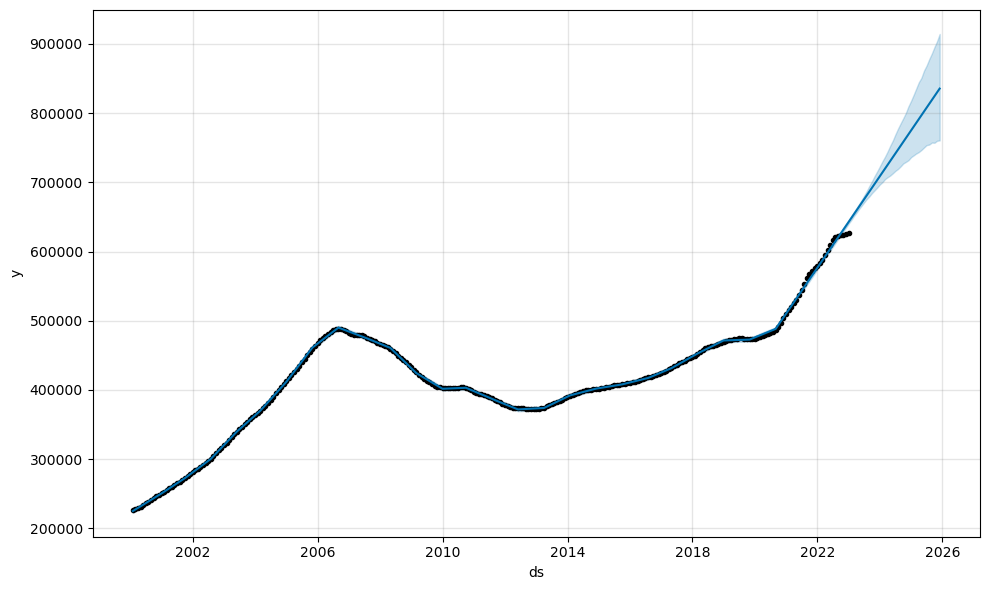

In [25]:
figNY = models2[0].plot(forecast2[0])
#add_changepoints_to_plot(figNY.gca(), models2[0], forecast2[0])

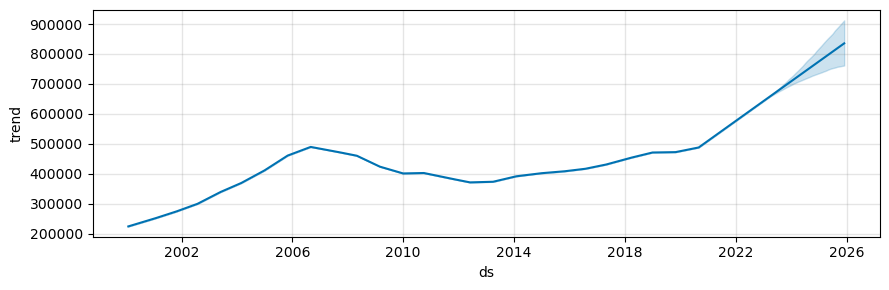

In [26]:
models2[0].plot_components(forecast2[0]);

LosAngelesCA

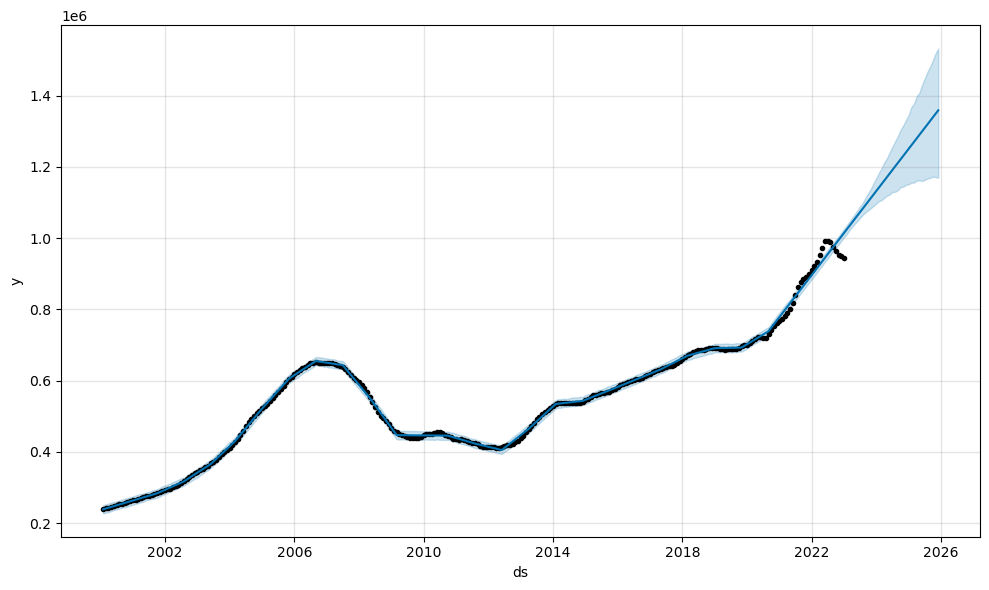

In [27]:
figCA = models2[1].plot(forecast2[1])
#add_changepoints_to_plot(figCA.gca(), models2[1], forecast2[1])

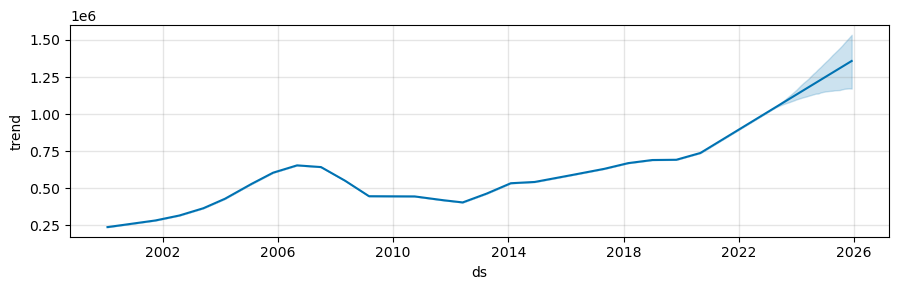

In [28]:
models2[1].plot_components(forecast2[1]);

RaleighNC

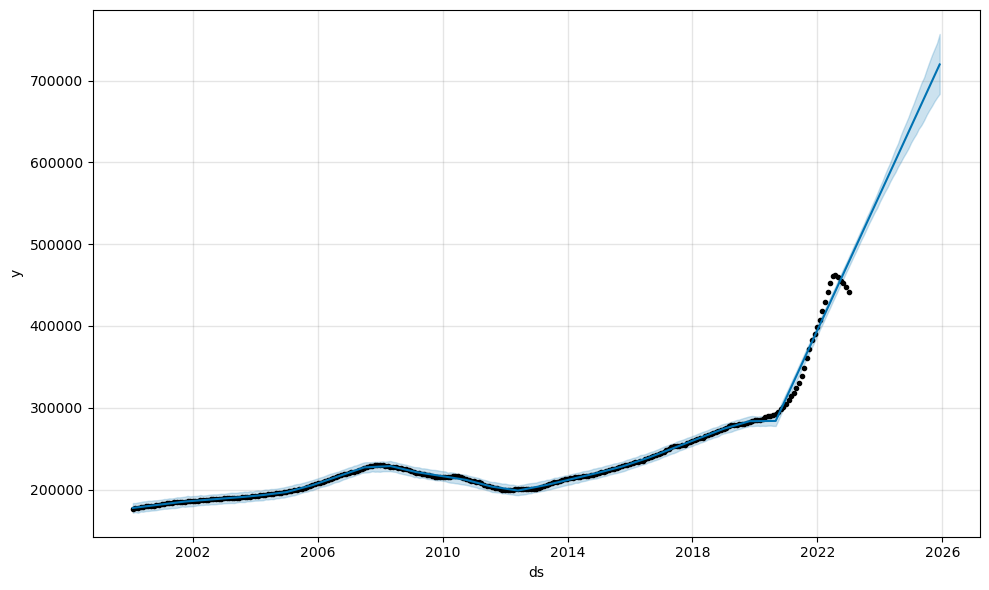

In [29]:
figNC = models2[2].plot(forecast2[2])
#add_changepoints_to_plot(figNC.gca(), models2[2], forecast2[2])

SaltLakeCityUT

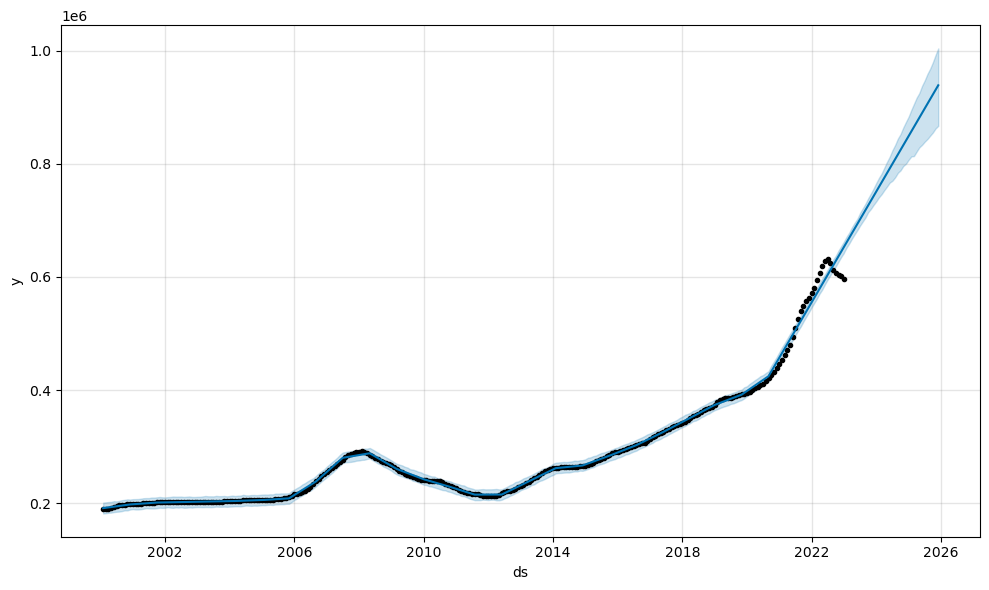

In [30]:
figUT = models2[3].plot(forecast2[3])
#add_changepoints_to_plot(figUT.gca(), models2[3], forecast2[3])

OklahomaCityOK

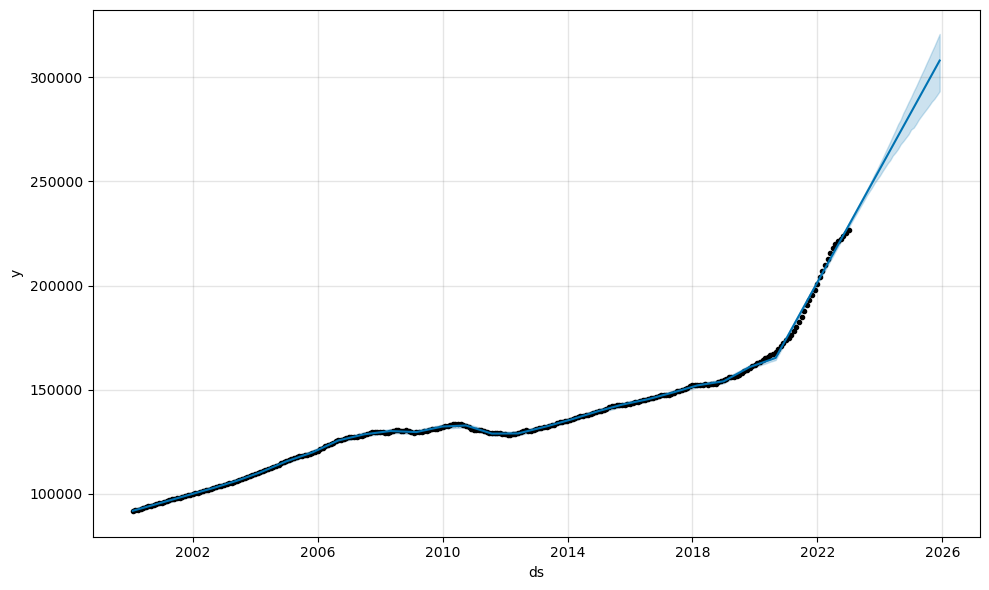

In [31]:
figOK = models2[4].plot(forecast2[4])
#add_changepoints_to_plot(figOK.gca(), models2[4], forecast2[4])